# Load Packages

In [1]:
using Dates, Optim

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")

printTable2

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Utility Function

The CRRA utility function is $U(x) = \frac{x^{1-\gamma}}{1-\gamma}$

In [3]:
U(x,γ)   =  x^(1-γ)/(1-γ)      #CRRA utility function, γ is the risk aversion
U_1(u,γ) = (u*(1-γ))^(1/(1-γ)) #inverse of utility function

U_1 (generic function with 1 method)

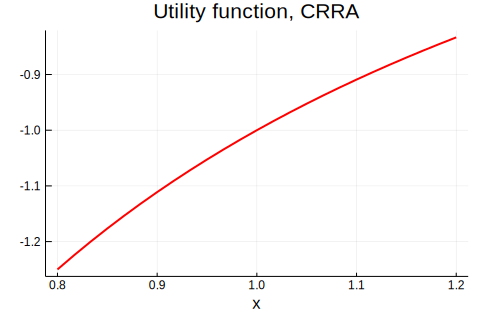

In [4]:
x = range(0.8,stop=1.2,length=25)

plot( x,U.(x,2),
      linecolor = :red,
      linewidth = 2,
      legend = false,
      title = "Utility function, CRRA",
      xlabel = "x" )

# Expected Utility

Recall: if $\pi_s$ is the probability of outcome ("state") $x_s$ and there are $S$ possible outcomes, then

$\text{E}U(x) = \sum\nolimits_{s=1}^{S} \pi_{s}U(x_s)$

In [5]:
EU(x,π,γ) = sum(π.*U.(x,γ))               #expected utility

EU (generic function with 1 method)

In [6]:
x₁ = 0.85               #possible outcomes
x₂ = 1.15
π₁ = 0.5                #probabilities of outcomes 
π₂ = 1 - π₁

state₁ = [x₁,U(x₁,2),π₁]     #for printing
state₂ = [x₂,U(x₂,2),π₂]

printblue("Different states: wealth, utility and probability:")
printTable([state₁ state₂],["state 1","state 2"],["wealth","utility","probability"])

Ex = sum([π₁,π₂].*[x₁,x₂])              #or EU([x₁,x₂],[π₁,π₂],0)
printlnPs("Expected wealth: ",Ex)

ExpUtil = EU([x₁,x₂],[π₁,π₂],2)
printlnPs("Expected utility:",ExpUtil)

Different states: wealth, utility and probability:
              state 1   state 2
wealth          0.850     1.150
utility        -1.176    -0.870
probability     0.500     0.500

Expected wealth:      1.000
Expected utility:    -1.023


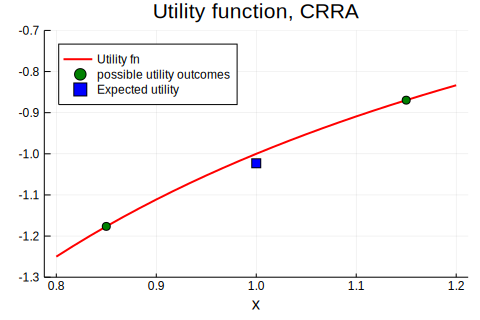

In [7]:
plot( x,U.(x,2),
      linecolor = :red,
      linewidth = 2,
      label = "Utility fn",
      ylim = (-1.3,-0.7),
      legend = :topleft,
      title = "Utility function, CRRA",
      xlabel = "x" )

scatter!([x₁,x₂],U.([x₁,x₂],2),markercolor=:green,label="possible utility outcomes")
scatter!([Ex],[ExpUtil],markercolor=:blue,marker=:rect,label="Expected utility")

# Certainty Equivalent

The certainty equivalent (here denoted $P$) is the sure (non-stochastic) value that solves 

$U(P) = \text{E}U(x)$

The code below solves for $P$ by inverting the utility function. This is applied to different values of risk aversion.

Notice that the expected wealth level in this example is 1.

In [8]:
γ  = [0;2;5;10;25;50;100]             #different risk aversions
L  = length(γ) 

(ceq,ERx) = (fill(NaN,L),fill(NaN,L))
for i = 1:L
    #local EU_i                         #only needed in REPL/script
    EU_i   = EU([x₁,x₂],[π₁,π₂],γ[i])     #expected utility with γ[i]
    ceq[i] = U_1(EU_i,γ[i])             #inverting the utility fn
    ERx[i] = Ex/ceq[i] - 1              #required net return
end

printblue("risk aversion and certainly equivalent (recall: E(wealth) = $Ex):")
printTable([γ ceq ERx],["γ","certainty eq","Risk premium"],fill("",L),width=15)

risk aversion and certainly equivalent (recall: E(wealth) = 1.0):
              γ   certainty eq   Risk premium
          0.000          1.000          0.000
          2.000          0.977          0.023
          5.000          0.947          0.056
         10.000          0.912          0.097
         25.000          0.875          0.143
         50.000          0.862          0.160
        100.000          0.856          0.168



# Portfolio Choice with One Risky Asset

In the example below, the investor maximizes $\text{E}\ln (1+R_{p})\text{, with }R_{p}=vR_{1} + (1-v)R_{f}$ by choosing $v$. There are two possible outcomes for $R_{1}$ with equal probabilities.

This particular problem can be solved by pen and paper, but this becomes very difficult when the number of states increases - and even worse when there are many assets. To prepare for these tricker cases, we apply a numerical optimization algorithm.

In [9]:
"""
    EUlog

Calculate expected utility (log(1+Rp)) from investing into one risky and one riskfree asset

v: scalar
π: S vector (S possible "states")
R: S vector, return of the risky asset in different states
Rf: scalar, riskfree rate
"""
function EUlog(v,π,Re,Rf)         #expected utility, utility fn is logarithmic
    R  = Re .+ Rf
    Rp = v*R .+ (1-v)*Rf          #portfolio return
    eu = sum(π .* log.(1.0.+Rp))  #expected utility
    return eu
end

EUlog

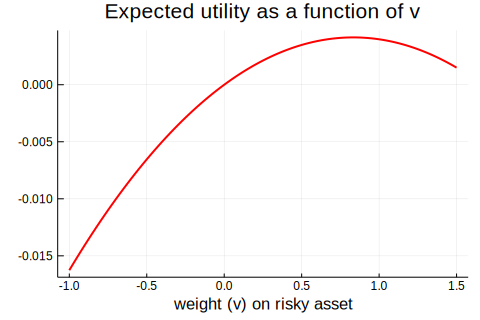

In [10]:
v = range(-1,stop=1.5,length=101)    #try different weights on risky asset
L = length(v)
EUv = fill(NaN,L)
for i = 1:L
    EUv[i] = EUlog(v[i],[0.5,0.5],[-0.10,0.12],0)
end

plot( v,EUv,
      linecolor = :red,
      linewidth = 2,
      legend = false,
      title = "Expected utility as a function of v",
      xlabel = "weight (v) on risky asset" )

In [11]:
Sol = optimize(v->-EUlog(v,[0.5,0.5],[-0.10,0.12],0),-1,1)  #minimize -EUlog
printlnPs("Optimum at: ",Optim.minimizer(Sol))

println("Compare with the figure")

Optimum at:      0.833
Compare with the figure


# Portfolio Choice with Several Risky Assets

This optimization problem has two risky assets and a general CRRA utility function. Numerical optimization is still straightforward.

In [12]:
"""
    EUcrra

Calculate expected utility from investing into n risky assets and one riskfree asset

v:  n vector (weights on the n risky assets)
π:  S vector (S possible "states")
R:  nxS matrix, each column is the n vector of returns in one of the states
Rf: scalar, riskfree rate
γ:  scalar, risk aversion
"""
function EUcrra(v,π,R,Rf,γ)
    S = length(π)
    Rp = fill(NaN,S)
    for i = 1:S           #portfolio return in each state
        Rp[i] = v'R[:,i] + (1-sum(v))*Rf
    end
    eu = EU(1.0.+Rp,π,γ)  #expected utility when using portfolio v
    return eu
end

EUcrra

In [13]:
ROutComes = [-0.03 0.08 0.20;           #2 assets, 3 states
             -0.04 0.22 0.15]           #cell[i,j] is asset i in state j
π = [1/3,1/3,1/3]                       #probs of the states
Rf = 0.065

Sol = optimize(v->-EUcrra(v,π,ROutComes,Rf,5),[-0.6,1.2])     #minimize -EUcrra
printlnPs("optimal portfolio weights on the risky assets from max EUcrra(): ",Optim.minimizer(Sol))

optimal portfolio weights on the risky assets from max EUcrra():     -0.726     1.317


# Mean-Variance and the Telser Criterion

Let $\mu$ be a vector of expected returns and $\Sigma$ be the covariance matrix of the investible assets.

The Telser criterion solves the problem

$\max_{v} \mu_{p} \: \text{ subject to} \:  \text{VaR}_{95\%} < 0.1$,

where $\mu_{p} = v'\mu+(1-v)R_f$ is the expected portfolio return.

If the returns are normally distributed then 

$\text{VaR}_{95\%} = -(\mu_p - 1.64\sigma_p)$,

where $\sigma_p = \sqrt{v'\Sigma v}$ is the standard deviation of the portfolio return.

The figure below illustrates that the optimal portfolio is on the CLM (when the returns are normally distributed)

In [14]:
include("jlFiles/MvCalculations.jl")    #functions for traditional MV frontiers

MVTangencyP

In [15]:
μ = [9; 6]/100                     #means
Σ = [ 256  0;
      0    144]/10000
Rf = 1/100

mustar  = range(Rf,stop=0.1,length=101)
L       = length(mustar)

(StdRp,StdRpRf) = (fill(NaN,L),fill(NaN,L))
for i = 1:L
    StdRp[i]   = MVCalc(mustar[i],μ,Σ)[1]
    StdRpRf[i] = MVCalcRf(mustar[i],μ,Σ,Rf)[1]
end

VaRRestr = -0.1 .+ 1.64*StdRpRf;

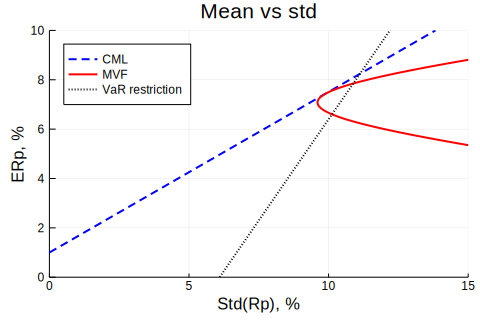

In [16]:
plot( [StdRpRf StdRp StdRpRf]*100,[mustar mustar VaRRestr]*100,
      linestyle = [:dash :solid :dot],
      linecolor = [:blue :red :black],
      linewidth = 2,
      label = ["CML" "MVF" "VaR restriction"],
      xlim = (0,15),
      ylim = (0,10),
      legend = :topleft,
      title = "Mean vs std",
      xlabel = "Std(Rp), %",
      ylabel = "ERp, %" )